In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

import time
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
torch.set_default_dtype(torch.float64)

In [4]:
class DNN(nn.Module):
    def __init__(self, neurons, activation):

        super(DNN, self).__init__()
        self.activation = activation
        self.n_layers = len(neurons)
        self.dense = {}
        self.nn_layers = nn.ModuleList()

        for i in range(self.n_layers-1):
            self.dense[str(i)] = nn.Linear(neurons[i], neurons[i+1])
            nn.init.xavier_uniform_(self.dense[str(i)].weight)
            nn.init.zeros_(self.dense[str(i)].bias)
            self.nn_layers.append(self.dense[str(i)])
            
    def forward(self, *args):
        x = torch.cat(args,1)
        activation = self.activation
        for i in range(self.n_layers-2):
            x = activation(self.dense[str(i)](x))
        i = self.n_layers-2
        return self.dense[str(i)](x)

In [5]:
device='cuda'
torch.manual_seed(0)

dim_x = 1
dim_z = 10
k_sensors = 41
B_size=64
B_x = torch.randn([dim_x,B_size//2], device=device)
B_z = torch.randn([dim_z,B_size//2], device=device)

save_path='GAN_PCN'
if not os.path.exists(save_path):
    os.makedirs(save_path)
with open(save_path+'/B_x.pickle', 'wb') as f:
    pickle.dump(B_x, f, pickle.HIGHEST_PROTOCOL)
with open(save_path+'/B_z.pickle', 'wb') as f:
    pickle.dump(B_z, f, pickle.HIGHEST_PROTOCOL)

p=64
net_size_Gx = [B_size,64,64,p]
net_size_Gz = [B_size,64,64,p]
net_size_D = [k_sensors,64,64,64,64,1]

def FEx(x):
    x_sin = torch.sin(torch.matmul(x,B_x))
    x_cos = torch.cos(torch.matmul(x,B_x))
    return torch.concat([x_cos,x_sin],-1)

def FEz(x):
    x_sin = torch.sin(torch.matmul(x,B_z))
    x_cos = torch.cos(torch.matmul(x,B_z))
    return torch.concat([x_cos,x_sin],-1)

oGx = DNN(net_size_Gx, activation=torch.tanh).to(device)
oGz = DNN(net_size_Gx, activation=torch.tanh).to(device)
oD = DNN(net_size_D, activation=torch.relu).to(device)

Gx = torch.compile(oGx)
Gz = torch.compile(oGz)
D = torch.compile(oD)

acti = torch.tanh
def G(X, Z):
    X = FEx(X)
    Z = FEz(Z)
    outx = acti(Gx(X))
    outz = Gz(Z)
    out = torch.matmul(outz,outx.T)
    return out

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

N_train = 20000
lc = 0.2
sigma = 0.3
x_grid = np.linspace(-1,1,k_sensors).reshape(-1,1)
kernel = ConstantKernel(constant_value=sigma**2, constant_value_bounds="fixed") * RBF(length_scale=lc, length_scale_bounds="fixed")
gpr = GaussianProcessRegressor(kernel=kernel)

mu = np.sin(np.pi*x_grid)
k_data = mu + gpr.sample_y(x_grid, N_train)

x_k = torch.tensor(x_grid,device=device)
k_data = torch.tensor(k_data.T,device=device)

In [7]:
def compute_lossD(Z, K):
    sigma = torch.sigmoid
    K_gen = G(x_k, Z)
    Dreal = sigma(D(K))
    Dfake = sigma(D(K_gen))
    lossD = -torch.log(Dreal).mean()-torch.log(1-Dfake).mean()

    return lossD

def compute_lossG(Z):
    sigma = torch.sigmoid
    K_gen = G(x_k, Z)
    Dfake = sigma(D(K_gen))
    lossG = torch.log(1-Dfake).mean()
    return lossG

def updateD(Z,K):
    optimizerD.zero_grad()
    lossD = compute_lossD(Z,K)
    lossD.backward()
    optimizerD.step()

def updateG(Z):
    optimizerG.zero_grad()
    lossG = compute_lossG(Z)
    lossG.backward()
    optimizerG.step()

In [8]:
torch.manual_seed(0)

optimizerD = torch.optim.RMSprop(D.parameters(), lr=2e-4)
G_params = list(Gx.parameters())+list(Gz.parameters())
optimizerG = torch.optim.RMSprop(G_params, lr=5e-5)

num_epochs = 10000
st = time.time()
for epoch in range(num_epochs):
    z = torch.randn([N_train,dim_z], device=device)
    alpha = torch.randn([N_train,1], device=device)
    updateD(z, k_data)
    updateG(z)
torch.save(D.state_dict(), save_path+'/paramsD')
torch.save(Gx.state_dict(), save_path+'/paramsGx')
torch.save(Gz.state_dict(), save_path+'/paramsGz')

print(f"{time.time()-st} seconds")

61.80121731758118 seconds


In [9]:
torch.manual_seed(0)

N_test = 20000
m_test = 41
with torch.no_grad():
    x_test = torch.linspace(-1,1,m_test,device=device).reshape(-1,1)
    z_test = torch.randn([N_test,dim_z],device=device)
    k_gen = G(x_test, z_test).cpu()
    k_mean, k_std = k_gen.mean(0), k_gen.std(0)

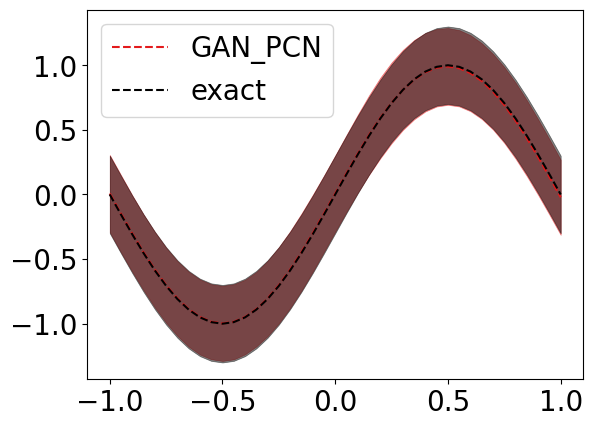

In [10]:
colors = [plt.cm.Paired(i) for i in range(20)]
x_test_ = x_test.flatten().cpu()

plt.plot(x_test_,k_mean,'--',label='GAN_PCN', color=colors[5])
plt.fill_between(x_test_, k_mean+k_std, k_mean-k_std, alpha=0.5, linewidth=.5, color=colors[5])

plt.plot(x_test_.flatten(),torch.sin(torch.pi*x_test_), '--',label='exact', color='k')
plt.fill_between(x_test_, torch.sin(torch.pi*x_test_)+0.3*torch.ones_like(x_test_), torch.sin(torch.pi*x_test_)-0.3*torch.ones_like(x_test_), alpha=0.5, linewidth=.5, color='k')
plt.legend()

In [ ]:
!kill -9 {os.getpid()}